# Training and evaluating Singing Voice Detectors

In [1]:
import sys
sys.path.append('../vocaldetection/')
import sklearn
import utils
import json
import os
import pandas as pd
import numpy as np
import seaborn as sns
import librosa
import numpy as np
from scipy.io import arff
import scipy.signal
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
%matplotlib inline

I know that the best parameters for training SVM and RF on this dataset are C=0.1 for SVM and nE=100 for RF. [WHY??]

Then, I can just train the models with these parameters and see how the results on confusion changes.

For each set of descriptors, I can do a cross validation evaluation and see the accuracy for each classifier.

Then, I select the greater accuracy to be my reference of ceiling confusion.

In [2]:
features = ['MFCC','VV','FL','SC','SF']

In [3]:
labels = ['absent','present']

In [4]:
# Path for features calculated with Lehner Code
f = '/media/DISCO2TB/datasets/MedleyDB/Features/ICASSP2014/MFCC_29_30_0_0.5_0dt/300_200_300/'
fluct_path = '/media/DISCO2TB/datasets/MedleyDB/Features/ICASSP2014/FLUCT_720_164_10548_240_30/40_20_40/'
flat_path = '/media/DISCO2TB/datasets/MedleyDB/Features/ICASSP2014/FLAT_720_164_10548_240_30/40_20_40/'
nsd_path = '/media/DISCO2TB/datasets/MedleyDB/Features/ICASSP2014/NSD_720_164_10548_240_30/40_20_40/'
# Read features and labels
FEAT_PATH = '/media/DISCO2TB/datasets/MedleyDB/Features/'# os.environ["FEAT_PATH"]
AUDIO_PATH = os.environ["AUDIO_PATH"]
PIECES = os.environ["PIECES_JSON"]
SPLITS = 'split_train_test_10.json' #os.environ["PIECES_JSON"]

In [5]:
# Old function to plot Confusion Matrix
def plot_cm(cm):
    fig, ax = plt.subplots()
    ax.imshow(cm, interpolation='nearest', cmap='gray')
    for i, line in enumerate(cm):
        for j, l in enumerate(line):
            ax.text(j, i, l, size=20, color='green')
    ax.set_xticks(range(len(cm)))
    ax.set_xticklabels(labels)
    ax.set_yticks(range(len(cm)))
    ax.set_yticklabels(labels)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    plt.show()

In [5]:
music_files = []

with open(PIECES) as json_file:  
    data = json.load(json_file)
    
    for music in data.keys():
        music_files.append(music)

# Save aggregated features

### Calculate Vocal Variance Separated

In [5]:
# vocal variance parameters 
FRAMESIZE = 2205
HOPSIZE = 441
SR = 22050
# Function taken from https://github.com/kyungyunlee/ismir2018-revisiting-svd/blob/master/lehner_randomforest/vocal_var.py
def vocal_var(mfcc):
    ''' Compute vocal variance
    '''
    vv = np.empty([mfcc.shape[0], 5])
    for i in range(mfcc.shape[0]):
        for j in range(5):
            vv[i][j] = np.var(mfcc[max(0, i - 5): min(mfcc.shape[0], i + 6), j + 1])
    return vv


def aggregate_feature(feat, agg_function):
    ''' Compute feature aggregation
    '''
    agg = np.empty([round(0.5+feat.shape[0]/10),feat.shape[1]])
    
    i = 0
    k = 0
    while i < feat.shape[0]:
        for j in range(feat.shape[1]):
            agg[k][j] = agg_function(feat[max(0, i - 15): min(feat.shape[0], i + 25), j])
        i += 10
        k += 1
    return agg

In [115]:
train_features = []
train_labels = []

for tf in music_files:
    try:
        dataset = arff.loadarff(f+tf+'_MIX.arff')
        mfcc = pd.DataFrame(dataset[0]).values
        print (f+tf+'_MIX.arff')
    except FileNotFoundError:
        print ('File not found: ',f+tf+'_MIX.arff')
        continue
        
    print (mfcc.shape)
    
    # Calculate VV because it is not included on Lehner feature pack
    vv = vocal_var(mfcc)
    print (vv.shape)
        
    try:
        dataset = arff.loadarff(fluct_path+tf+'_MIX.arff')
        fluct = pd.DataFrame(dataset[0]).values
        print (fluct_path+tf+'_MIX.arff')
    except FileNotFoundError:
        print ('File not found: ',fluct_path+tf+'_MIX.arff')
        continue
    
    fl = aggregate_feature(fluct, np.var)

    print (fluct.shape, fl.shape)
    
    try:
        dataset = arff.loadarff(flat_path+tf+'_MIX.arff')
        flatness = pd.DataFrame(dataset[0]).values
        print (flat_path+tf+'_MIX.arff')
    except FileNotFoundError:
        print ('File not found: ',flat_path+tf+'_MIX.arff')
        continue
    
    flat = aggregate_feature(flatness, np.mean)

    print (flatness.shape, flat.shape)
    
    try:
        dataset = arff.loadarff(nsd_path+tf+'_MIX.arff')
        contraction = pd.DataFrame(dataset[0]).values
        print (nsd_path+tf+'_MIX.arff')
    except FileNotFoundError:
        print ('File not found: ',nsd_path+tf+'_MIX.arff')
        continue
    
    cont = aggregate_feature(contraction, np.var)

    print (contraction.shape, cont.shape)
    
    


    lbl = np.load(FEAT_PATH+tf+"_labels_200ms.npy")
    print (lbl.shape)
    
    feature_vector = []
    for idx in range(len(lbl)):
        #if lbl[idx] != -1: # Remove 
        feature_vector.append(np.concatenate((mfcc[idx], vv[idx], fl[idx], flat[idx], cont[idx]), axis=0))
        #    train_labels.append(lbl[idx])
        #else:
        #    continue
            #feature_vector.append(data[idx])
        
    print (len(feature_vector))
    np.save(FEAT_PATH+'AGG/'+tf+'_agg.npy',feature_vector)
    print ('Saved in',FEAT_PATH+'AGG/'+tf+'_agg.npy')
    
    # Store the feature vector and corresponding label in integer format
    for idx in range(len(feature_vector)):
        train_features.append(feature_vector[idx])
        #train_labels.append(lbl[idx])
        
    print (len(train_features))
    print (len(train_labels))
    

/media/DISCO2TB/datasets/MedleyDB/Features/ICASSP2014/MFCC_29_30_0_0.5_0dt/300_200_300/AClassicEducation_NightOwl_MIX.arff
(857, 60)
(857, 5)
/media/DISCO2TB/datasets/MedleyDB/Features/ICASSP2014/FLUCT_720_164_10548_240_30/40_20_40/AClassicEducation_NightOwl_MIX.arff
(8572, 17) (858, 17)
/media/DISCO2TB/datasets/MedleyDB/Features/ICASSP2014/FLAT_720_164_10548_240_30/40_20_40/AClassicEducation_NightOwl_MIX.arff
(8572, 17) (858, 17)
/media/DISCO2TB/datasets/MedleyDB/Features/ICASSP2014/NSD_720_164_10548_240_30/40_20_40/AClassicEducation_NightOwl_MIX.arff
(8572, 17) (858, 17)
(857,)
857
Saved in /media/DISCO2TB/datasets/MedleyDB/Features/AGG/AClassicEducation_NightOwl_agg.npy
857
0
/media/DISCO2TB/datasets/MedleyDB/Features/ICASSP2014/MFCC_29_30_0_0.5_0dt/300_200_300/AimeeNorwich_Child_MIX.arff
(946, 60)
(946, 5)
/media/DISCO2TB/datasets/MedleyDB/Features/ICASSP2014/FLUCT_720_164_10548_240_30/40_20_40/AimeeNorwich_Child_MIX.arff
(9463, 17) (947, 17)
/media/DISCO2TB/datasets/MedleyDB/Featu

## Recover 10 splits dataset into train and test sets

In [5]:
train_files = []
test_files = []
with open(SPLITS) as json_file:  
    data = json.load(json_file)
#print (data)
    for spl in range(len(data)):
        train_files.append([])
        test_files.append([])
        # Load train data
        for music in data[spl]['train']:
            train_files[spl].append(music)
        #    print (music)

        # Load test data
        #print ('Test data')
        for music in data[spl]['test']:
            test_files[spl].append(music)


## Read features and labels

In [6]:
import separated_features_training as sf
X_train, y_train = sf.read_agg_features(train_files[0])

...........................................
> Load data completed!


In [7]:
X_test, y_test = sf.read_agg_features(test_files[0])

..................
> Load data completed!


# Find hiperparameters for RF

In [7]:
import separated_features_training as sf

In [8]:
rows_list = []

for spl in range(10):
    
    X_train, y_train = sf.read_agg_features(train_files[spl])
    grid_search = sf.rf_param_selection(X_train, y_train, 5)
    break

...........................................
> Load data completed!
Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 1

In [9]:
grid_search.best_estimator_


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Evaluate pieces with post processing

In [6]:
from sklearn.ensemble import RandomForestClassifier
import separated_features_training as sf
from tqdm import tqdm_notebook as tqdm

In [7]:
features = np.arange(116) # mfcc[idx], vv[idx], fl[idx], flat[idx], cont[idx]
features = ['mfcc_'+str(i) for i in range(30)]+['dt_mfcc_'+str(i) for i in range(30)]+['vv_'+str(i) for i in range(5)]
features += ['fl_'+str(i) for i in range(17)]+['sf_'+str(i) for i in range(17)]+['sc_'+str(i) for i in range(17)]
features = np.array(features)

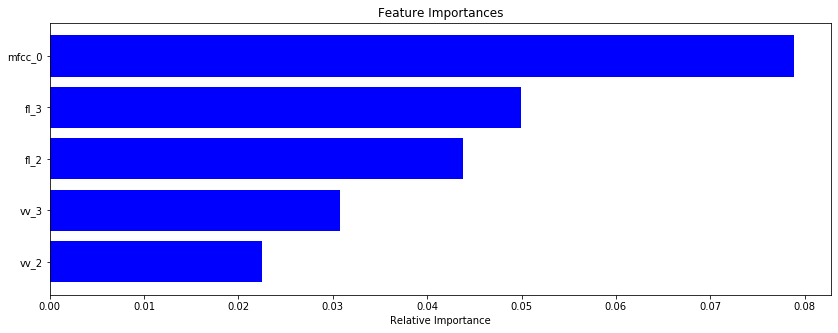

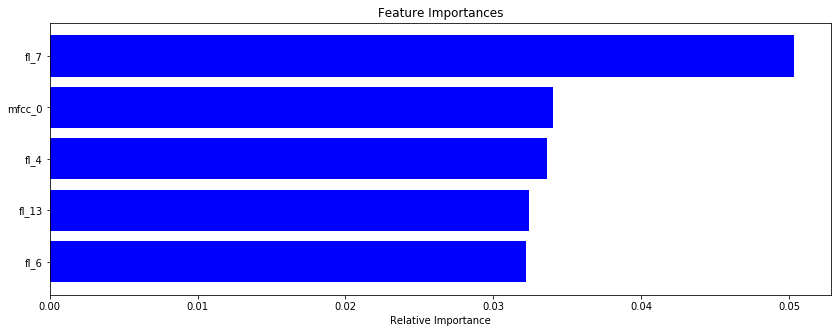

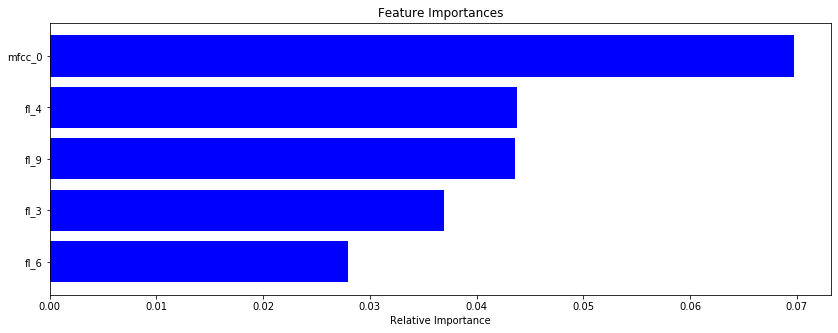

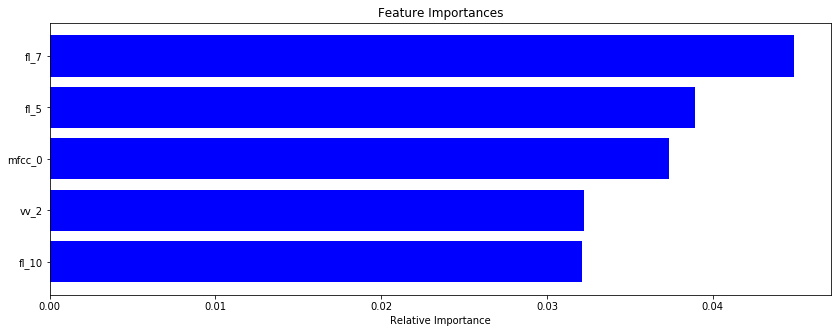

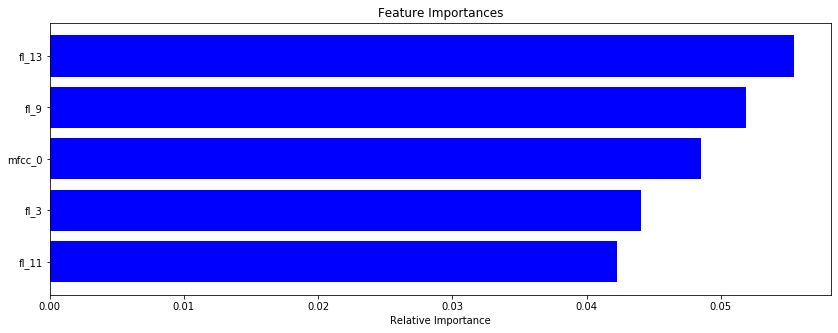

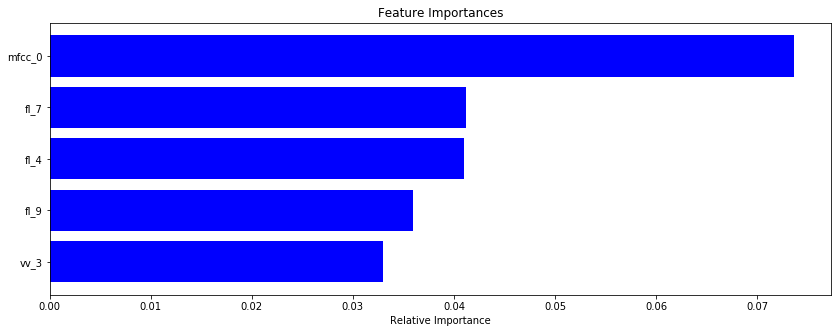

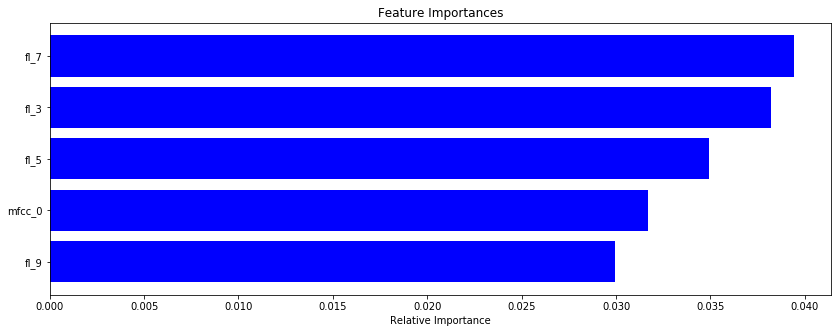

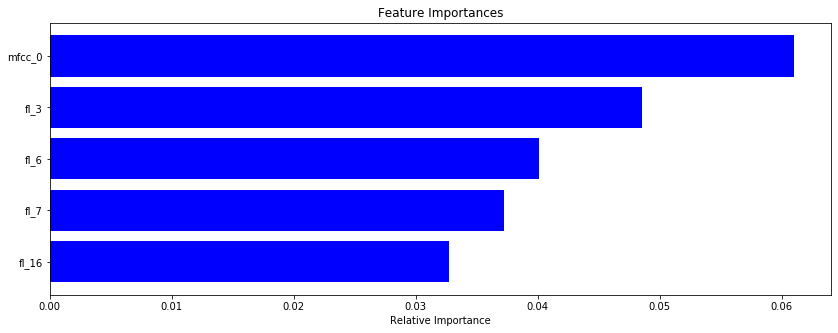

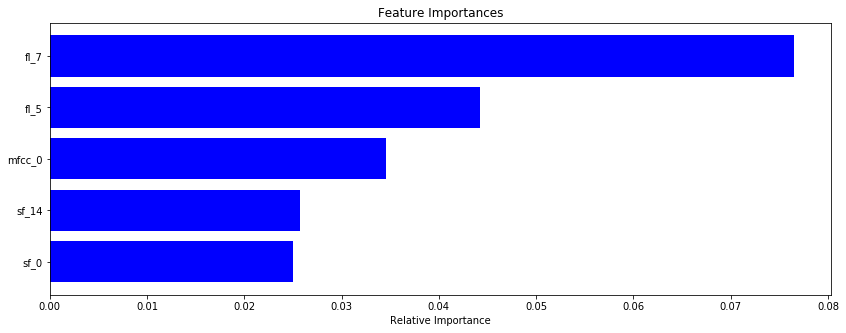

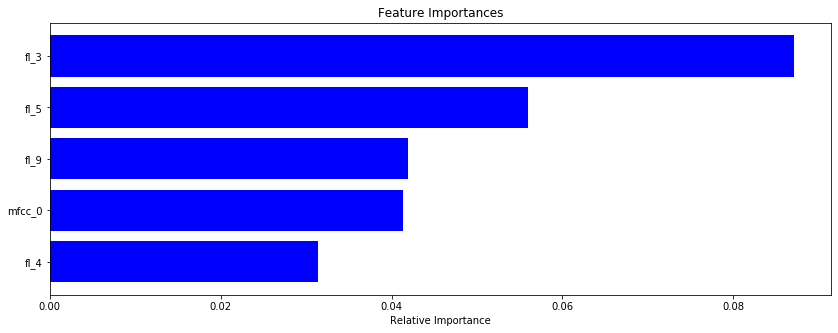

In [8]:
rows_list = []
rf_models = []
saco = []

for spl in range(10):
    
    clf3=RandomForestClassifier(bootstrap=True, 
                                max_depth=30,
                                max_features='sqrt',
                                n_estimators=10)
    
    X_train, y_train = sf.read_agg_features(train_files[spl], verbose=False)
    X_test, y_test = sf.read_agg_features(test_files[spl], verbose=False)
    
    clf3.fit(X_train, y_train)
    rf_models.append(clf3)
    
    for piece_name in tqdm(test_files[spl]):
        piece_features, piece_labels = sf.read_agg_features([piece_name], verbose=False)

        proba = clf3.predict_proba(piece_features)
        proba = proba[:,1]

        #
        pred_labels = clf3.predict(piece_features)
        acc = sklearn.metrics.accuracy_score(piece_labels, pred_labels)
        P,R,F1,_ = precision_recall_fscore_support(piece_labels, pred_labels, average='binary')
        rows_list.append({'split':spl,
                          'piece':piece_name,
                          'type':'predict',
                          'ACC':acc,
                          'P':P,'R':R,'F1':F1})

        #
        pred_filt = scipy.signal.medfilt(pred_labels,kernel_size=5)
        acc = sklearn.metrics.accuracy_score(piece_labels, pred_filt)
        P,R,F1,_ = precision_recall_fscore_support(piece_labels, pred_filt, average='binary')
        rows_list.append({'split':spl,
                          'piece':piece_name,
                          'type':'predict filtered',
                          'ACC':acc,
                          'P':P,'R':R,'F1':F1})

        #
        thresh = scipy.signal.medfilt(proba,kernel_size=5)
        thresh = np.where(scipy.signal.medfilt(thresh,kernel_size=5) >= 0.5,1,0)
        acc = sklearn.metrics.accuracy_score(piece_labels, thresh)
        P,R,F1,_ = precision_recall_fscore_support(piece_labels, thresh, average='binary')
        rows_list.append({'split':spl,
                          'piece':piece_name,
                          'type':'threshold prob',
                          'ACC':acc,
                          'P':P,'R':R,'F1':F1})

        # Plot all together
#         sns.set_style(style='white')
#         plt.figure(figsize=(14,3))
#         plt.plot(piece_labels+2)
#         plt.plot(pred_labels+1)
#         plt.plot(pred_filt)
#         plt.plot(proba-1)
#         plt.plot(scipy.signal.medfilt(proba,kernel_size=5)-2)
#         plt.plot(thresh-3)
#         plt.legend(['Original Label', 'Predicted Label', 'Filter Prediction', 
#                     'Probabilities', 'Filter Probabilities', 'Threshold Prob'], bbox_to_anchor=(1, 1))

    plt.figure(figsize=(14,5))
    importances = clf3.feature_importances_
    indices = np.argsort(importances)

    plt.figure(1)
    plt.title('Feature Importances')
    plt.barh(range(len(indices))[111:], importances[indices][111:], color='b', align='center')
    plt.yticks(range(len(indices))[111:], features[indices][111:])
    saco += [x for x in features[indices][111:]]
    plt.xlabel('Relative Importance')
    plt.show()
    

In [9]:
results_rf = pd.DataFrame(rows_list)

In [10]:
results_rf = results_rf.sort_values('F1')

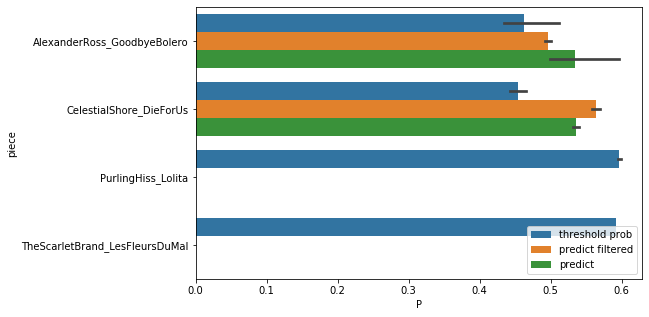

In [13]:
plt.figure(figsize=(8,5))
ax = sns.barplot(y='piece', x='P', hue='type', data=results_rf[results_rf['P']<.6])
ax.legend(title='', loc=4)

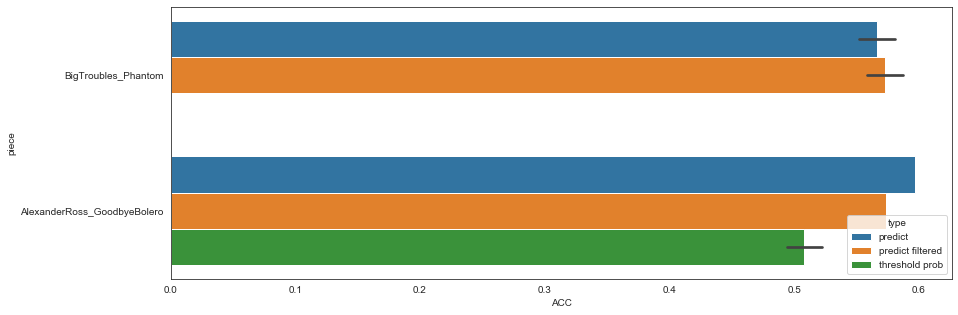

In [36]:
plt.figure(figsize=(14,5))
sns.barplot(y='piece', x='F1', hue='type', data=results_rf[results_rf['ACC']<0.6])

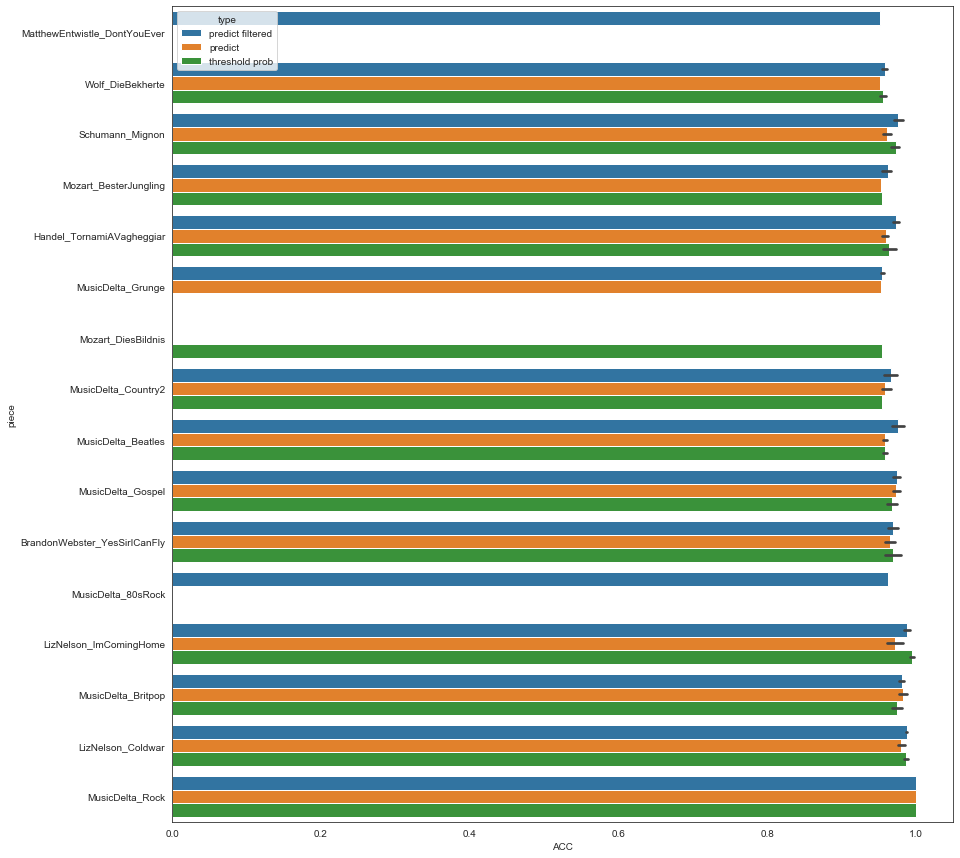

In [37]:
plt.figure(figsize=(14,15))
sns.barplot(y='piece', x='ACC', hue='type', data=results_rf[results_rf['ACC']>0.95])

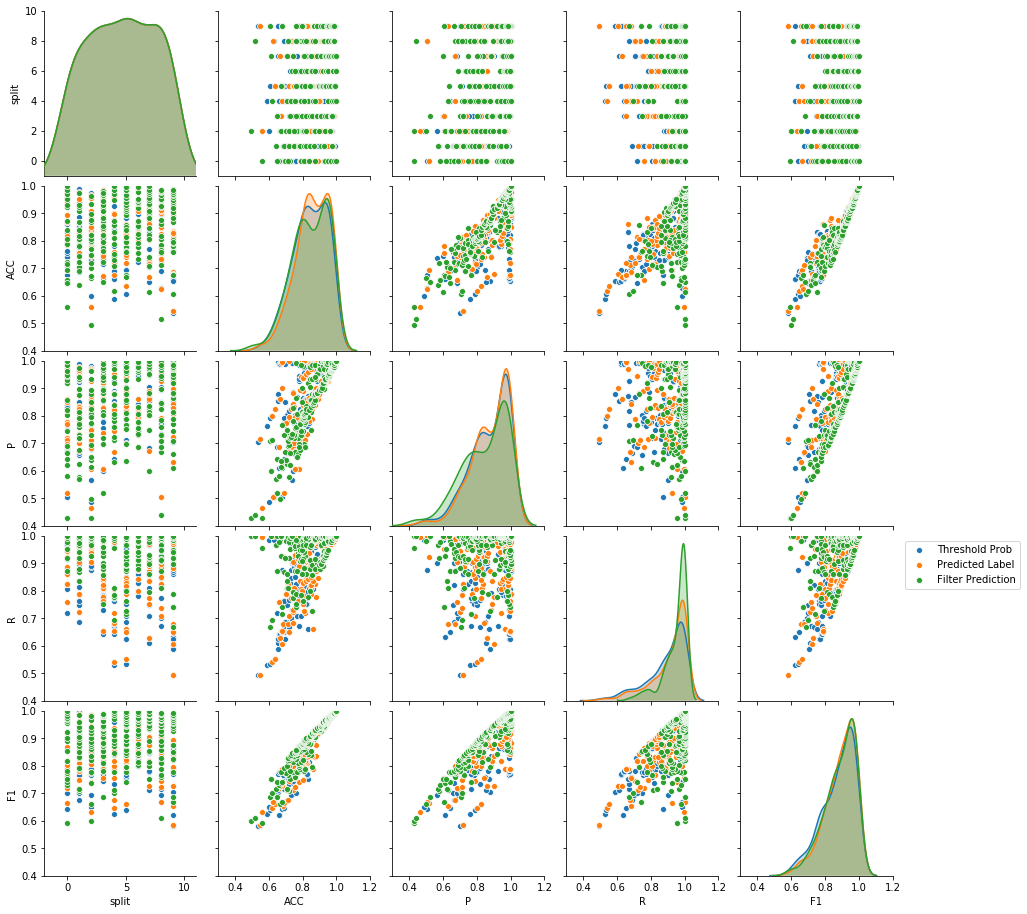

In [23]:
g = sns.pairplot(data=results_rf, hue='type')
g.set(ylim=(0.4,1))
g.set(xlim=(0.3,1.2))
g.axes[0,0].set_ylim((-1,10))
g.axes[0,0].set_xlim((-2,11))
g._legend.remove()
plt.legend([ 'Threshold Prob', 'Predicted Label', 'Filter Prediction'], bbox_to_anchor=(1.05, 1), loc=0)

Text(0.5, 0, 'Relative Importance')

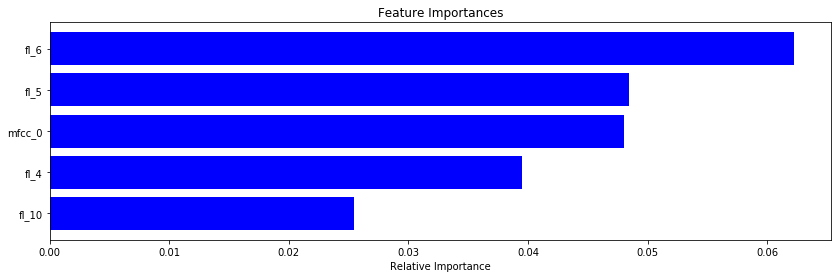

In [25]:
plt.figure(figsize=(14,4))

features = np.arange(116) # mfcc[idx], vv[idx], fl[idx], flat[idx], cont[idx]
features = ['mfcc_'+str(i) for i in range(30)]+['dt_mfcc_'+str(i) for i in range(30)]+['vv_'+str(i) for i in range(5)]
features += ['fl_'+str(i) for i in range(17)]+['sf_'+str(i) for i in range(17)]+['sc_'+str(i) for i in range(17)]
features = np.array(features)
importances = clf3.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices))[111:], importances[indices][111:], color='b', align='center')
plt.yticks(range(len(indices))[111:], features[indices][111:])
plt.xlabel('Relative Importance')

In [22]:
saco.count()

TypeError: count() takes exactly one argument (0 given)

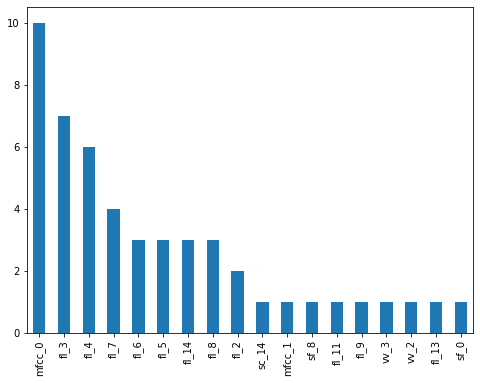

In [28]:
from collections import Counter
plt.figure(figsize=(8,6))

pd.Series(Counter(saco)).sort_values(ascending=False).plot(kind='bar')

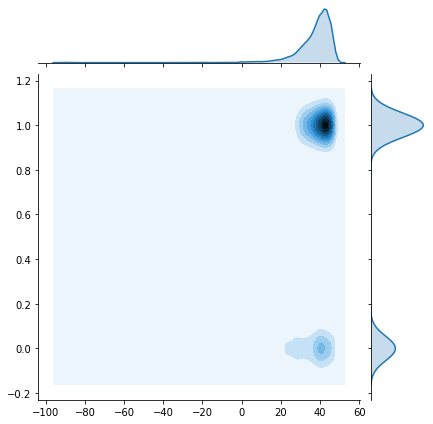

In [29]:
X, y = sf.read_agg_features(train_files[spl]+test_files[spl], verbose=False)
sns.jointplot(X[:,0],y,kind="kde")

In [11]:
import shap

In [ ]:
shap_values = shap.TreeExplainer(clf3).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values[1], X_train)